In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40257")
client

<Client: 'tcp://127.0.0.1:40257' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:40257' processes=7 threads=56, memory=206.47 GiB>

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [6]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [7]:
fesom01w = cat.FESOM(datatype='int', season='fma').to_dask().chunk({'depth':6})

fesom01w

<xarray.Dataset>
Dimensions:  (depth: 48, lat: 1000, lon: 1000, time: 90)
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30
Data variables:
    salt     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    temp     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    w        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Sep 09 15:44:25 2021: cdo mergetime 2012-02_01_w_cubic....

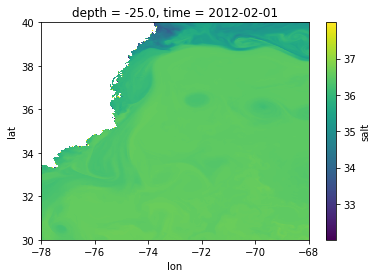

In [42]:
fesom01w.salt.isel(time=0,depth=5).where(fesom01w.salt.isel(time=0,depth=5)>32.).where(fesom01w.salt.isel(time=0,depth=5)<38.).plot()

In [8]:
ww = fesom01w.w

ww

<xarray.DataArray 'w' (time: 90, depth: 48, lat: 1000, lon: 1000)>
dask.array<rechunk-merge, shape=(90, 48, 1000, 1000), dtype=float32, chunksize=(10, 6, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

In [9]:
grav = 9.81
w_path = f'{SCRATCH}/region01/FESOM/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0.chunk({'depth':6,'lat':-1,'lon':-1})


bw = -sig0w * grav / 1e3

bw

<xarray.DataArray 'sig0' (time: 90, depth: 48, lat: 1000, lon: 1000)>
dask.array<truediv, shape=(90, 48, 1000, 1000), dtype=float64, chunksize=(10, 6, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

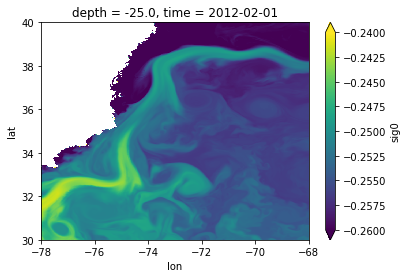

In [11]:
bw.isel(time=0,depth=5).plot(vmax=-.24, vmin=-.26)

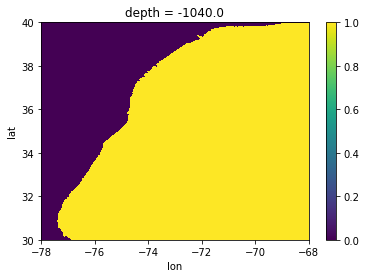

In [11]:
wet_mask = xr.DataArray(np.zeros_like(fesom01w.salt.isel(time=0)),
                        dims=['depth','lat','lon'],
                        coords={'depth':fesom01w.depth,
                                'lat':fesom01w.lat.data,
                                'lon':fesom01w.lon.data}
           )
wet_mask[:,1:-1,1:-1] = (~np.ma.masked_invalid(fesom01w.salt[0,:,1:-1,1:-1].where(fesom01w.salt[0,:,1:-1,1:-1]
                                                                                  >32.).where(fesom01w.salt[0,:,1:-1,1:-1]
                                                                                              <38.).data).mask).astype(np.float64)
wet_mask.isel(depth=-1).plot()

In [28]:
z10 = 2   # grid index of ~10m depth
nMLDw = z10 + np.abs((sig0w.isel(depth=slice(z10,None)).fillna(0.)
                      - sig0w.isel(depth=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='depth').compute()  # indexing needs loading
MLDw = (xr.ones_like(sig0w) 
        * fesom01w.depth).reset_coords(drop=True)[{'depth':nMLDw}] 

In [29]:
tmp_path = f'{SCRATCH}/region01/FESOM/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw.reset_coords(drop=True).chunk({'lat':200,'lon':200}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLD_fma.zarr


In [108]:
nMLDs = z10 + np.abs((sig0s.isel(depth=slice(z10,None)).fillna(0.)
                      - sig0s.isel(depth=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='depth').compute()  # indexing needs loading
MLDs = (xr.ones_like(sig0s) 
        * fesom01w.depth).reset_coords(drop=True)[{'depth':nMLDs}]  
# del nMLDs
MLDs

<xarray.DataArray (time_counter: 89, y: 763, x: 611)>
dask.array<reshape, shape=(89, 763, 611), dtype=float64, chunksize=(89, 763, 611), chunktype=numpy.ndarray>
Coordinates:
    deptht        (time_counter, y, x) float64 115.2 109.0 103.1 ... 70.72 70.72
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x

In [139]:
tmp_path = f'{SCRATCH}/region01/FESOM/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr


In [30]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLD_fma.zarr")
                   ).MLD.chunk({'time':10})
# MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLD_aso.zarr")).MLD
MLDw

<xarray.DataArray 'MLD' (time: 90, lat: 1000, lon: 1000)>
dask.array<rechunk-merge, shape=(90, 1000, 1000), dtype=float64, chunksize=(10, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

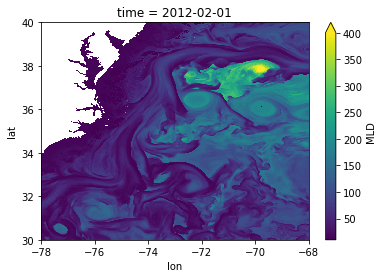

In [31]:
np.abs(MLDw.isel(time=0)).where(~np.ma.masked_invalid(fesom01w.salt.isel(time=0,depth=0)).mask).plot(vmax=400)

In [14]:
import gsw
xx, yy = np.meshgrid(fesom01w.lon, 
                     fesom01w.lat
                    )
ny, nx = xx.shape
dx = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                               coords={'lat':np.arange(ny),'lon':np.arange(.5,nx-1,1)}
                              ).interp(lon=np.arange(nx), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )
dy = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                               coords={'lat':np.arange(.5,ny-1,1),'lon':np.arange(nx)}
                              ).interp(lat=np.arange(ny), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )
dx

<xarray.DataArray (lat: 1000, lon: 1000)>
array([[963.9402524 , 963.94025241, 963.94025241, ..., 963.94025241,
        963.94025241, 963.94025241],
       [963.84300745, 963.84300745, 963.84300745, ..., 963.84300745,
        963.84300745, 963.84300745],
       [963.74573308, 963.74573308, 963.74573308, ..., 963.74573308,
        963.74573308, 963.74573308],
       ...,
       [852.90515288, 852.90515288, 852.90515288, ..., 852.90515288,
        852.90515288, 852.90515288],
       [852.78019513, 852.78019513, 852.78019513, ..., 852.78019513,
        852.78019513, 852.78019513],
       [852.65521135, 852.65521135, 852.65521135, ..., 852.65521135,
        852.65521135, 852.65521135]])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0

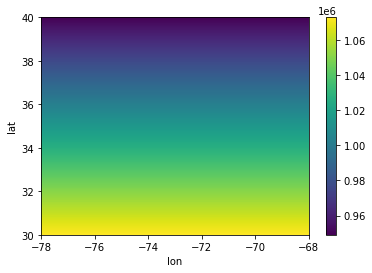

In [15]:
area = (dx * dy)

area.plot()

In [16]:
dlat = fesom01w.lat.diff('lat')[0]
dlon = fesom01w.lon.diff('lon')[0]

dxw = xr.DataArray(dx.interp(lon=np.arange(dx.lon.min()-dlon,dx.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dy.interp(lon=np.arange(dy.lon.min()-dlon,dy.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dx.interp(lat=np.arange(dx.lat.min()-dlat,dx.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dy.interp(lat=np.arange(dy.lat.min()-dlat,dy.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray (lat: 1000, lon: 1000)>
array([[963.9402524 , 963.9402524 , 963.94025241, ..., 963.94025241,
        963.94025241, 963.94025241],
       [963.84300745, 963.84300745, 963.84300745, ..., 963.84300745,
        963.84300745, 963.84300745],
       [963.74573308, 963.74573308, 963.74573308, ..., 963.74573308,
        963.74573308, 963.74573308],
       ...,
       [852.90515287, 852.90515288, 852.90515288, ..., 852.90515288,
        852.90515288, 852.90515288],
       [852.78019513, 852.78019513, 852.78019513, ..., 852.78019513,
        852.78019513, 852.78019513],
       [852.65521135, 852.65521135, 852.65521135, ..., 852.65521135,
        852.65521135, 852.65521135]])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0

In [17]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(852.65521135)

In [18]:
kappa_w = xr.ones_like(wet_mask)

kappa_s = xr.ones_like(wet_mask)

In [19]:
filter_scale = 30000   # 30 km
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'lat':-1,'lon':-1}), 
        'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
        'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
        'area': area.chunk({'lat':-1,'lon':-1}), 
        'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
    }
)
filter_30km

Filter(filter_scale=30000, dx_min=array(852.65521135), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=39, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

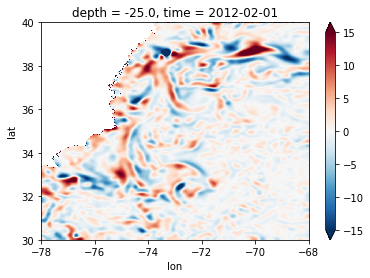

In [22]:
ww_filtered_to_30km = filter_30km.apply(ww.chunk({'lat':-1,'lon':-1}), dims=['lat','lon'])
# ww_filtered_to_50km.shape
(ww_filtered_to_30km.isel(time=0,depth=5)
 * 86400).plot(vmax=15,vmin=-15,cmap='RdBu_r')

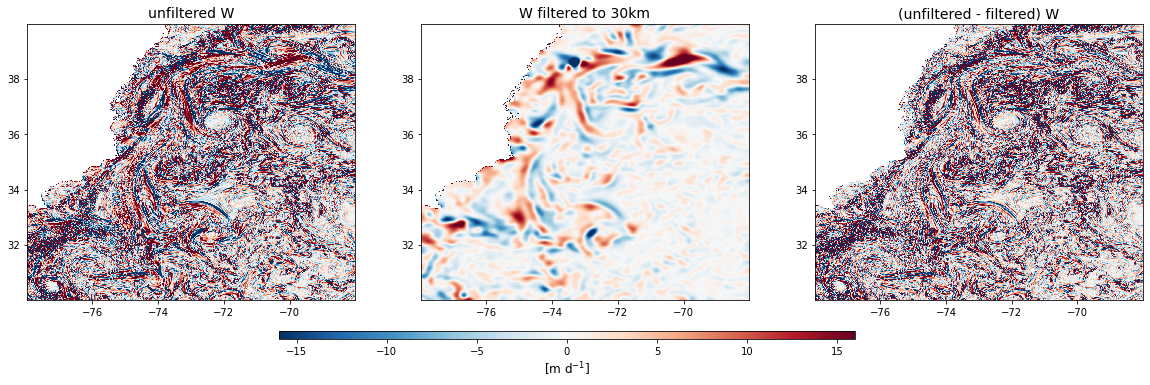

In [23]:
vmin = -16
vmax = 16

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                       fesom01w.lat.isel(lat=slice(1,-1)),
                       (ww*86400).isel(time=0, depth=5,
                                       lat=slice(1,-1),lon=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'},
                       shading='auto', rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=14)

axs[1].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                  fesom01w.lat.isel(lat=slice(1,-1)),
                  (ww_filtered_to_30km.isel(time=0,depth=5,
                                            lat=slice(1,-1),lon=slice(1,-1))*86400), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[1].set_title('W filtered to 30km', fontsize=14)

axs[2].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                  fesom01w.lat.isel(lat=slice(1,-1)),
                  ((ww.isel(time=0,depth=5) 
                    - ww_filtered_to_30km.isel(time=0,depth=5)
                   )*86400).isel(lat=slice(1,-1),lon=slice(1,-1)), 
                  vmax=vmax, vmin=vmin,
                  cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) W', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.3, 0.15, 0.4, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01_wp_Feb-01.pdf')

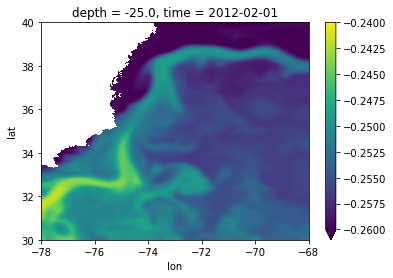

In [20]:
bw_filtered_to_30km = filter_30km.apply(bw.chunk({'lat':-1,'lon':-1}), dims=['lat','lon'])

(bw_filtered_to_30km.isel(time=0,depth=5)).plot(vmin=-.26, vmax=-.24)

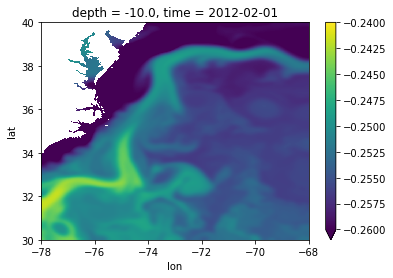

In [34]:
(bw_filtered_to_30km.isel(time=0,depth=2)).plot(vmin=-.26, vmax=-.24)

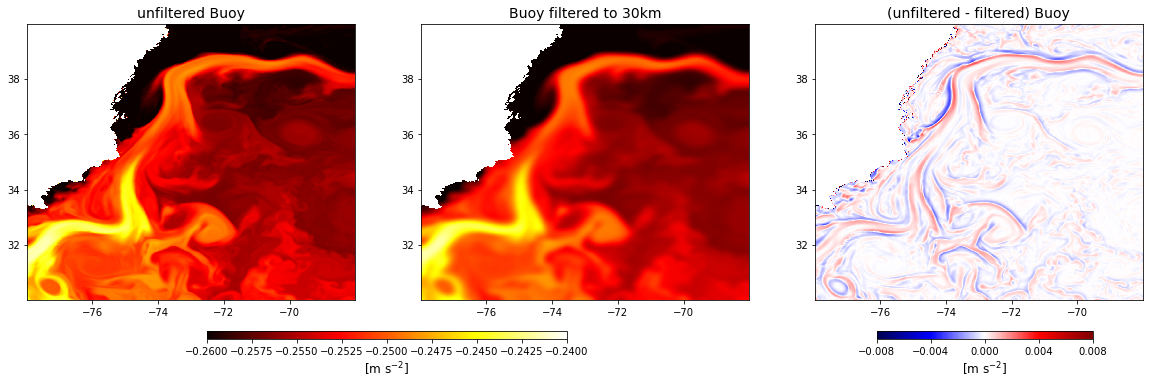

In [24]:
vmin = -.26
vmax = -.24

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                       fesom01w.lat.isel(lat=slice(1,-1)),
                       (bw).isel(time=0,depth=5,lat=slice(1,-1),lon=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='hot', 
                       shading='auto', rasterized=True
)
axs[0].set_title(r'unfiltered Buoy', fontsize=14)

axs[1].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                  fesom01w.lat.isel(lat=slice(1,-1)),
                  bw_filtered_to_30km.isel(time=0,depth=5,
                                           lat=slice(1,-1),lon=slice(1,-1)), 
                  vmin=vmin, vmax=vmax, 
                  cmap='hot', 
                  shading='auto', rasterized=True
)
axs[1].set_title(r'Buoy filtered to 30km', fontsize=14)

im2 = axs[2].pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                        fesom01w.lat.isel(lat=slice(1,-1)),
                        (bw.isel(time=0,depth=5) 
                         - bw_filtered_to_30km.isel(time=0,depth=5)
                        ).isel(lat=slice(1,-1),lon=slice(1,-1)), 
                        vmax=.008, vmin=-.008,
                        cmap='seismic', 
                        shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) Buoy', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.25, 0.15, 0.25, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)
cbaxes = fig.add_axes([0.715, 0.15, 0.15, 0.018]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.008,-.004,0.,.004,.008]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01_bp_Feb-01.pdf')

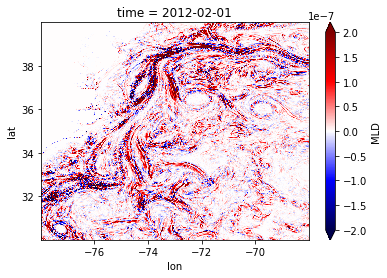

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
gcs://meom-ige-scratch/roxyboy/region01/FESOM/wb-30km_z0-MLD_fma.zarr


In [33]:
zp1s = .5*(fesom01w.depth[1:].data + fesom01w.depth[:-1].data)
dzp1s = xr.DataArray(np.concatenate((np.concatenate((np.array([np.abs(.5*fesom01w.depth[0].data)]),
                                     np.abs(np.diff(zp1s)))),
                                     np.array([np.abs(np.diff(zp1s))[-1]]))),
                     dims='depth', coords={'depth':fesom01w.depth.data})

wpbpw = xr.zeros_like(MLDw.isel(lat=slice(1,-1),lon=slice(1,-1))).load()

for i in range(len(wpbpw.time)):
    wpbpw[i] = ((((ww.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)) 
                   - ww_filtered_to_30km.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)))
                  * (bw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)) 
                     - bw_filtered_to_30km.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)))
                 ) * dzp1s
                ).where(fesom01w.depth >= MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))
                       ).sum('depth',skipna=True) 
                / np.abs(MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)))
               ).chunk({'lat':200,'lon':200})
    if i == 0:
        wpbpw[i].plot(vmin=-2e-7, vmax=2e-7,
                      cmap='seismic')
        plt.show()
    print(i)
    
tmp_path = f'{SCRATCH}/region01/FESOM/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

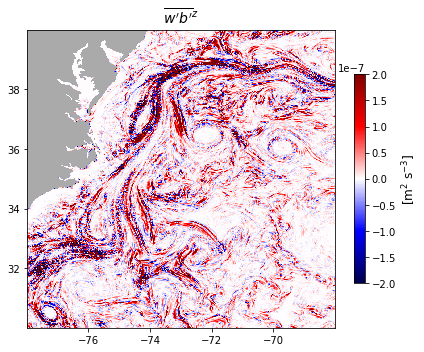

In [12]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/wb-30km_z0-MLD_fma.zarr")).wpbp

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
                  fesom01w.lat.isel(lat=slice(1,-1)),
                  wpbpw.isel(time=0).where(fesom01w.salt.isel(time=0,depth=0,lat=slice(1,-1),lon=slice(1,-1))!=0.),
                  vmin=-2e-7, vmax=2e-7,
                  cmap='seismic', shading='auto', rasterized=True
)
ax.pcolormesh(fesom01w.lon.isel(lon=slice(1,-1)), 
              fesom01w.lat.isel(lat=slice(1,-1)),
              wet_mask.where(wet_mask!=1).isel(depth=0,lat=slice(1,-1),lon=slice(1,-1)),
              vmin=-1, vmax=2,
              cmap='binary', shading='auto', rasterized=True)

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01_wpbpz_Feb-01.pdf')